## Binary Classifcation based on 3 layers neural network

First layer
* $Z^1 = W^1X + b^1 : X$ denotes the input data
* $A^1 = g^1(Z^1) : g^1$ is the activation function at the first layer

Second layer
* $Z^2 = W^2A^1 + b^2$
* $A^2 = g^2(Z^2) : g^2$ is the activation function at the second layer

Third layer
* $Z^3 = W^3A^2 + b^3$
* $A^3 = g^3(Z^3) : g^3$ is the activation function at the third (output) layer


## Activation Function

* Sigmoid : $g(z) = {1 \over (1 + \exp^{-z})}$

* tanh : $g(z) = {\exp^z - \exp^{-z} \over \exp^z + \exp^{-z}}$

* ReLU : $g(z) = max(0, z)$

* Leaky ReLU : $g(z) = max(\alpha * z, z)$



* $yh_i = \sigma(Z^3_i)$
* $z_i = Z^3_i$

## The lossfunction is defined by
* $\mathcal{L} = \frac{1}{n} \sum_{i=1}^n f_i(W^1, W^2, W^3, b^1, b^2, b^3) + (lamda / 2) * ((W^{[1]})^2 + (W^{[2]})^2 + (W^{[3]})^2)$
* $f_i(W^1, W^2, W^3, b^1, b^2, b^3) = - y_i \log yh_i - (1 - y_i) \log (1 - yh_i)$

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os

In [3]:
transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])

LABEL_IDX = 10000

# Get data

- The dataset consists of human images and horse images for the training and the validation
- The classifier should be trained using the training set
- The classifier should be tested using the validation set

In [4]:
def get_train_dataset():
    #train_data_path = 'relative path of training data set'
    train_data_path = './horse-or-human/train'
    trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
    # change the valuse of batch_size, num_workers for your program
    # if shuffle=True, the data reshuffled at every epoch 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=1)
    
    TRAIN_SIZE = len(trainloader)
    
    train_data = np.random.randn(LABEL_IDX + 1, TRAIN_SIZE)
    
    # load training images of the batch size for every iteration
    for i, data in enumerate(trainloader):

        # inputs is the image
        # labels is the class of the image
        inputs, labels = data
        
        train_data[:LABEL_IDX, i] = inputs.numpy().flatten()[:]
        train_data[LABEL_IDX, i] = labels[0]
    
    return TRAIN_SIZE, train_data
        
def get_validation_dataset():
    validation_data_path = './horse-or-human/validation'
    valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
    # change the valuse of batch_size, num_workers for your program
    valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=1) 
    
    VALIDATION_SIZE = len(valset)
    
    validation_data = np.random.randn(LABEL_IDX + 1, VALIDATION_SIZE)
        
    # load validation images of the batch size for every iteration
    for i, data in enumerate(valloader):
        
        # inputs is the image
        # labels is the class of the image
        inputs, labels = data
                
        validation_data[:LABEL_IDX, i] = inputs.numpy().flatten()[:]
        validation_data[LABEL_IDX, i] = labels[0]
    
    return VALIDATION_SIZE, validation_data

In [5]:
# get dataset
TRAIN_SIZE, training_data = get_train_dataset()
VALIDATION_SIZE, validation_data = get_validation_dataset()


# 사용할 상수들 정의
m = TRAIN_SIZE
TOLERATION = 10e-6
#n1, n2 = 500, 100
#n1, n2 = 10, 5

LEAKY_RELU_RATE = 10e-3

# Functions

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

def tanh(z):
    return np.tanh(z)

def d_tanh(z):
    return (1 - (tanh(z) ** 2))

def relu(z):
    return np.maximum(0, z)

def d_relu(z):
    return np.where(z <= 0, 0, 1)

def leaky_relu(z):
    return np.maximum(LEAKY_RELU_RATE * z, z)

def d_leaky_relu(z):
    return np.where(z <= 0, LEAKY_RELU_RATE, 1)

def get_hx(w1, w2, w3, b1, b2, b3, data, type):
    A1 = sigmoid(np.dot(w1, data[:LABEL_IDX, :]) + b1)
    A2 = sigmoid(np.dot(w2, A1) + b2)
    
    hx = sigmoid(np.dot(w3, A2) + b3)
    return hx

def cross_entropy(w1, w2, w3, b1, b2, b3, data, size, type):
    hx = get_hx(w1, w2, w3, b1, b2, b3, data, type)
    
    d = np.nan_to_num(data[LABEL_IDX, :] * np.log(hx)) + np.nan_to_num((1 - data[LABEL_IDX, :]) * np.log(1 - hx))

    return -d

def loss(w1, w2, w3, b1, b2, b3, data, size, type, lamda_rate):
    d = cross_entropy(w1, w2, w3, b1, b2, b3, data, size, type)

    w_sum = (np.sum(np.square(w1)) + np.sum(np.square(w2)) + np.sum(np.square(w3))) * (lamda_rate / 2)
    
    return (np.sum(d) + w_sum) / size

def accuracy(w1, w2, w3, b1, b2, b3, data, size, type):
    hx = get_hx(w1, w2, w3, b1, b2, b3, data, type)
    hit = 0
    
    for i in range(size):
        if hx[0][i] > 0.5:
            if data[LABEL_IDX, i] == 1:
                hit += 1
        else:
            if data[LABEL_IDX, i] == 0:
                hit += 1
                
    return hit / size

# main logic

In [7]:
def gradient_descent(n1, n2, lamda_rate, LEARNING_RATE):
    #LEARNING_RATE = 0.002
    #LEARNING_RATE = 0.01
    type = 1
    w1 = np.random.randn(n1, LABEL_IDX) * np.sqrt(2 / (m + n1))
    b1 = np.random.randn(n1, 1) * 0.01
    w2 = np.random.randn(n2, n1) * np.sqrt(2 / (n1 + n2))
    b2 = np.random.randn(n2, 1) * 0.01
    w3 = np.random.randn(1, n2) * np.sqrt(2 / (n2 + 1))
    b3 = np.random.randn(1, 1) * 0.01
    
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []
    
    now_loss = 0
    before_loss = 0
    
    label = training_data[LABEL_IDX, :].reshape(1, m)
    
    while True:
        z1 = np.dot(w1, training_data[:LABEL_IDX, :]) + b1
        a1 = sigmoid(z1)
        z2 = np.dot(w2, a1) + b2
        a2 = sigmoid(z2)
        z3 = np.dot(w3, a2) + b3
        a3 = sigmoid(z3)
        
        dz3 = a3 - label
        dw3 = (np.dot(dz3, a2.T)) / m
        db3 = np.sum(dz3, axis = 1, keepdims = True) / m
        
        dz2 = np.dot(w3.T, dz3) * d_sigmoid(z2)
        dw2 = (np.dot(dz2, a1.T)) / m
        db2 = np.sum(dz2, axis = 1, keepdims = True) / m
        
        dz1 = np.dot(w2.T, dz2) * d_sigmoid(z1)
        dw1 = (np.dot(dz1, training_data[:LABEL_IDX, :].T)) / m
        db1 = np.sum(dz1, axis = 1, keepdims = True) / m
        
        # back propagation
        
        w3 = (1 - ((lamda_rate * LEARNING_RATE) / m)) * w3 - LEARNING_RATE * dw3
        b3 = b3 - LEARNING_RATE * db3
        
        w2 = (1 - ((lamda_rate * LEARNING_RATE) / m)) * w2 - LEARNING_RATE * dw2
        b2 = b2 - LEARNING_RATE * db2
        
        w1 = (1 - ((lamda_rate * LEARNING_RATE) / m)) * w1 - LEARNING_RATE * dw1
        b1 = b1 - LEARNING_RATE * db1

        now_loss = loss(w1, w2, w3, b1, b2, b3, training_data, TRAIN_SIZE, type, lamda_rate)

        training_loss.append(now_loss)
        training_accuracy.append(accuracy(w1, w2, w3, b1, b2, b3, training_data, TRAIN_SIZE, type))
        validation_loss.append(loss(w1, w2, w3, b1, b2, b3, validation_data, VALIDATION_SIZE, type, lamda_rate))
        validation_accuracy.append(accuracy(w1, w2, w3, b1, b2, b3, validation_data, VALIDATION_SIZE, type))

        if abs(now_loss - before_loss) < TOLERATION:
            break
        before_loss = now_loss

        #print(now_loss)

    #print(training_loss)
    #print(training_accuracy)
    #print(validation_loss)
    #print(training_accuracy[-1])
    #print(validation_accuracy)
    #print(validation_accuracy[-1])

    return training_loss, training_accuracy, validation_loss, validation_accuracy

* Apply the gradient descent algorithm

* Plot the training loss at every iteration
* Plot the testing loss at every iteration
* Plot the training accuracy at every iteration
* Plot the testing accuracy at every iteration

* print validation loss and validation accuracy (when the best validation accuracy is achieved over all the iterations)

# setting
* Initialize : He
* First layer activation function : sigmoid
* Second layer activation function : sigmoid
* Third layer activation function : sigmoid

* n1 = 10, n2 = 5
* learning rate = 0.01
* lamda_rate = bias(10000), variance(0.01), best(32)

In [8]:
n1 = 10
n2 = 5

Bias (large lamda)


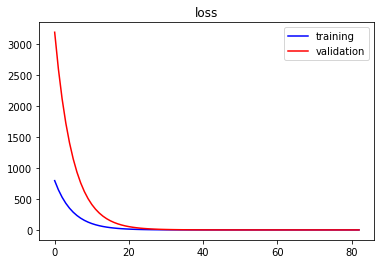

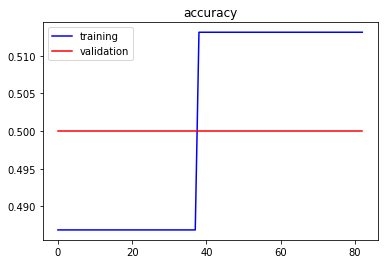

the table for the final accuracy and loss with training and validation datasets


dataset                         loss                              accuracy
training                    0.6930135286                    0.5131450828
validation                  0.6933592637                    0.5000000000


In [9]:
# bias(large lamda)
lamda_rate = 10000
LEARNING_RATE = 0.01

print('Bias (large lamda)')
training_loss, training_accuracy, validation_loss, validation_accuracy = gradient_descent(n1, n2, lamda_rate, LEARNING_RATE)
iteration = range(len(training_loss))

plt.title('loss')
plt.plot(iteration, training_loss, color = 'blue', label = 'training')
plt.plot(iteration, validation_loss, color = 'red', label = 'validation')
plt.legend()
plt.show()

plt.title('accuracy')
plt.plot(iteration, training_accuracy, color = 'blue', label = 'training')
plt.plot(iteration, validation_accuracy, color = 'red', label = 'validation')
plt.legend()
plt.show()

print('the table for the final accuracy and loss with training and validation datasets\n\n')
print('dataset' + ' ' * 25 + 'loss' + ' ' * 30 + 'accuracy')
print('training' + ' ' * 20 + '%.10f' % training_loss[-1] + ' ' * 20 + '%.10f' % training_accuracy[-1])
print('validation' + ' ' * 18 + '%.10f' % validation_loss[-1] + ' ' * 20 + '%.10f' % validation_accuracy[-1])

Variance (small lamda)


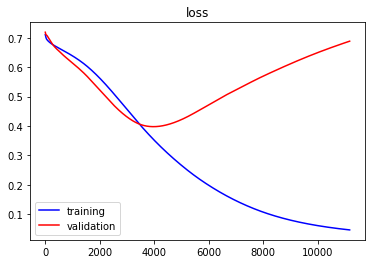

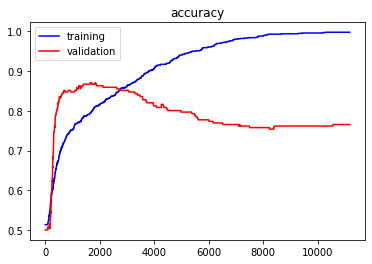

the table for the final accuracy and loss with training and validation datasets


dataset                         loss                              accuracy
training                    0.0467287675                    0.9980525803
validation                  0.6884280313                    0.7656250000


In [10]:
# Variance(small lamda)
lamda_rate = 0.01
LEARNING_RATE = 0.01

print('Variance (small lamda)')
training_loss, training_accuracy, validation_loss, validation_accuracy = gradient_descent(n1, n2, lamda_rate, LEARNING_RATE)
iteration = range(len(training_loss))

plt.title('loss')
plt.plot(iteration, training_loss, color = 'blue', label = 'training')
plt.plot(iteration, validation_loss, color = 'red', label = 'validation')
plt.legend()
plt.show()

plt.title('accuracy')
plt.plot(iteration, training_accuracy, color = 'blue', label = 'training')
plt.plot(iteration, validation_accuracy, color = 'red', label = 'validation')
plt.legend()
plt.show()

print('the table for the final accuracy and loss with training and validation datasets\n\n')
print('dataset' + ' ' * 25 + 'loss' + ' ' * 30 + 'accuracy')
print('training' + ' ' * 20 + '%.10f' % training_loss[-1] + ' ' * 20 + '%.10f' % training_accuracy[-1])
print('validation' + ' ' * 18 + '%.10f' % validation_loss[-1] + ' ' * 20 + '%.10f' % validation_accuracy[-1])

Best (appropriate lamda)


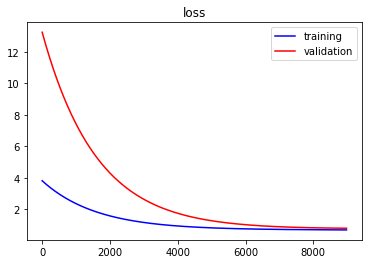

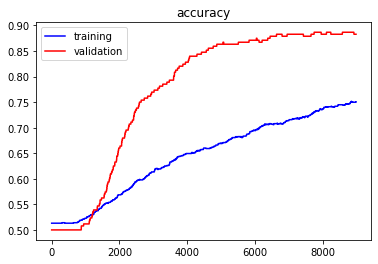

the table for the final accuracy and loss with training and validation datasets


dataset                         loss                              accuracy
training                    0.7010858184                    0.7507302824
validation                  0.8078738854                    0.8828125000


In [19]:
# Best(appropriate lamda)
lamda_rate = 32
LEARNING_RATE = 0.01

print('Best (appropriate lamda)')
training_loss, training_accuracy, validation_loss, validation_accuracy = gradient_descent(n1, n2, lamda_rate, LEARNING_RATE)
iteration = range(len(training_loss))

plt.title('loss')
plt.plot(iteration, training_loss, color = 'blue', label = 'training')
plt.plot(iteration, validation_loss, color = 'red', label = 'validation')
plt.legend()
plt.show()

plt.title('accuracy')
plt.plot(iteration, training_accuracy, color = 'blue', label = 'training')
plt.plot(iteration, validation_accuracy, color = 'red', label = 'validation')
plt.legend()
plt.show()

print('the table for the final accuracy and loss with training and validation datasets\n\n')
print('dataset' + ' ' * 25 + 'loss' + ' ' * 30 + 'accuracy')
print('training' + ' ' * 20 + '%.10f' % training_loss[-1] + ' ' * 20 + '%.10f' % training_accuracy[-1])
print('validation' + ' ' * 18 + '%.10f' % validation_loss[-1] + ' ' * 20 + '%.10f' % validation_accuracy[-1])